In [217]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qSMLM.psf.psf2d.psf2d import *
from scipy.special import comb

In [276]:
def _mu(theta,npixels,nparticles,patch_hw=5):
    x = np.arange(0,2*patch_hw); y = np.arange(0,2*patch_hw)
    X,Y = np.meshgrid(x,y)
    mu = np.zeros((npixels,npixels),dtype=np.float32)
    for n in range(nparticles):
        x0,y0,sigma,N0 = theta[:,n]
        patchx, patchy = int(round(x0))-patch_hw, int(round(y0))-patch_hw
        x0p = x0-patchx; y0p = y0-patchy
        lam = lamx(X,x0p,sigma)*lamy(Y,y0p,sigma)
        mu[patchx:patchx+2*patch_hw,patchy:patchy+2*patch_hw] += lam
    return mu

def ring(n,radius=3,phase=np.pi):
    thetas = np.arange(0,n,1)*2*np.pi/n
    xs = radius*np.cos(thetas+phase)
    ys = radius*np.sin(thetas+phase)
    return xs,ys

def computeP(theta,patch_hw=5):

    x = np.arange(0,2*patch_hw); y = np.arange(0,2*patch_hw)
    X,Y = np.meshgrid(x,y)
    npixels = config['npixels']
    nparticles = config['particles']
    P = np.zeros((nparticles, npixels*npixels))
    for n in range(nparticles):
        mu = np.zeros((npixels,npixels),dtype=np.float32)
        x0,y0,sigma,N0 = theta[:,n]
        patchx, patchy = int(round(x0))-patch_hw, int(round(y0))-patch_hw
        x0p = x0-patchx; y0p = y0-patchy
        lam = lamx(X,x0p,sigma)*lamy(Y,y0p,sigma)
        mu[patchx:patchx+2*patch_hw,patchy:patchy+2*patch_hw] += lam
        P[n,:] = mu.flatten()
    return P


def computeEind(npixels):
    """Get indexers for the E matrix"""
    x = np.ones((npixels**2,))
    mask = np.arange(len(x)) % npixels == 0
    x[mask] = 0; x = np.roll(x,-1)
    A = np.diag(x,k=1) #horizontally adjacent

    x = np.ones((npixels**2-npixels,))
    B = np.diag(x,k=npixels) #vertically adjacent
    
    x = np.ones((npixels**2-npixels,))
    mask = np.arange(len(x)) % npixels == 0
    x[mask] = 0; x = np.roll(x,-1)
    C = np.diag(x,k=npixels+1) #right diagonal
    
    x = np.ones((npixels**2-npixels,))
    mask = np.arange(len(x)) % npixels == 0
    x[mask] = 0
    D = np.diag(x,k=npixels-1) #left diagonal
    
    F = np.eye(npixels**2)
    Aind = np.where(A > 0); Bind = np.where(B > 0)
    Cind = np.where(C > 0); Dind = np.where(D > 0)
    Find = np.where(F > 0)
    return Aind,Bind,Cind,Dind,Find

def computeSind(npixels):
    """Get indexers for the covariance map"""
    checker = np.indices((2*npixels-1,2*npixels-1)).sum(axis=0) % 2
    checker = 1-checker
    checker[::2,:] *= 2
    checker[::2,:] += 2
    Vind = np.where(checker == 0); RLind = np.where(checker == 1)
    Hind = np.where(checker == 2); Dind = np.where(checker == 4)
    return Vind, RLind, Hind, Dind

def computeE(config,r=4,patch_hw=5,ring_radius=10):
    theta = np.zeros((4,config['particles']))
    nx,ny = config['npixels'],config['npixels']
    xsamp,ysamp = ring(config['particles'],radius=ring_radius)
    x0 = nx/2; y0 = ny/2
    theta[0,:] = xsamp + x0
    theta[1,:] = ysamp + y0
    theta[2,:] = config['sigma']
    theta[3,:] = config['N0']
    mu = _mu(theta,config['npixels'],config['particles'])
    
    npixels = config['npixels']
    Kmax = 2; #single photon counts only
    M = config['particles']
    Omega = np.zeros((Kmax+1,Kmax+1,npixels**2,npixels**2)) #need object of shape (K,K,npixels**2,npixels**2)
    P = computeP(theta) # nparticles, npixels**2 (columns are probs emitters emit into that pixel)
    for i in range(Kmax+1):
        for j in range(Kmax+1):
            B = np.load(config['bpath']+f'bin_{M}{i}{j}.npz')['B']
            Nc,_,_ = B.shape
            alpha = B[:,0,:]; beta = B[:,1,:]
            thisP = np.repeat(P[:,:,np.newaxis],Nc,axis=2) #nparticles, npixels**2, Nc
            alpha = np.repeat(alpha[:,np.newaxis,:],npixels**2,axis=1) #nparticles, npixels**2, Nc
            beta = np.repeat(beta[:,np.newaxis,:],npixels**2,axis=1) #nparticles, npixels**2, Nc
            alpha = np.swapaxes(alpha,0,2); beta = np.swapaxes(beta,0,2)
            P2alpha = np.power(thisP,alpha); P2beta = np.power(thisP,beta)
            R = np.sum(np.prod(P2alpha*P2beta,axis=0),axis=1)
            Omega[i,j,:,:] = R

    Chi = np.arange(0,Kmax+1,1)
    Chi = np.outer(Chi,Chi)
    Chi = Chi[:,:,np.newaxis,np.newaxis]
    E = np.sum(Chi*Omega,axis=(0,1))
    return E, mu


In [277]:
bpath = '/Users/cwseitz/Desktop/States/'
config = {"particles": 5,"npixels": 20,"sigma": 0.92,"N0": 0.5,"eta": 1.0,"bpath":bpath}
E,mu = computeE(config,ring_radius=3)
Eh,Ev,Er,El,Ed = computeEind(config['npixels'])
Vind, RLind, Hind, Dind = computeSind(config['npixels'])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [278]:
Ehvals = E[Eh]
Evvals = E[Ev]
Ervals = E[Er]
Elvals = E[El]
Edvals = E[Ed]

In [279]:
npixels = config['npixels']
CovR = np.zeros((2*npixels-1,2*npixels-1))
CovR[Vind] = Evvals #looks weird, probably indexing issue
CovR[RLind] = Ervals
CovR[Hind] = Ehvals
CovR[Dind] = Edvals

CovL = np.zeros((2*npixels-1,2*npixels-1))
CovL[Vind] = Evvals
CovL[RLind] = Elvals
CovL[Hind] = Ehvals
CovL[Dind] = Edvals

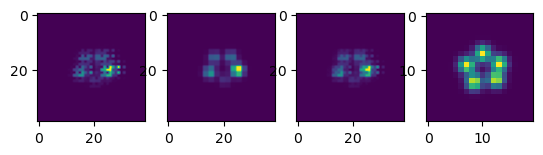

In [280]:
fig,ax=plt.subplots(1,4)
ax[0].imshow(CovL); ax[1].imshow(CovR); ax[2].imshow((CovL+CovR)/2); ax[3].imshow(mu)